## Wavespeed Inference

The basic approach here is to use a second neural network to infer a static x,y field which corresponds to wavespeed and thus ocean depth.

The outputs of this wavespeed NN are used as the squared_slowness calculations in the wavefunction loss terms. 

While the values of the learned wavefunction depend on time, the wavespeed depth field should only be a function of x,y position and tide height. (though for waves breaking on sand it can be expected to change slowly over the course of days as the sandbanks shift) 

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet

tb_logger = pl.loggers.TensorBoardLogger('logs/', name="wavespeed")
trainer = pl.Trainer(logger=tb_logger, limit_val_batches=1,
                     max_epochs=30, 
                     gpus=1 if torch.cuda.is_available() else None,)

wavefunc_model = LitSirenNet(hidden_features=256, hidden_layers=3, first_omega_0=1.5, hidden_omega_0=11.7, squared_slowness=0.23,
                             steps_per_vid_chunk=100, learning_rate=1e-4, grad_loss_scale=0, wavefunc_loss_scale=1e-7, 
                             wavespeed_loss_scale=1e-2)

trainer.fit(wavefunc_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


KeyError: 'wavespeed_loss_scalehidden_features'

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet


model = LitSirenNet.load_from_checkpoint('logs/best/baseline_wavefunc/checkpoints/epoch=5.ckpt')

In [ ]:
from surfbreak.datasets import WaveformVideoDataset, WaveformChunkDataset
wf_train_video_dataset = WaveformVideoDataset(ydim=120, xrange=(10,130), timerange=(0,61), time_chunk_duration_s=20, 
                                                     time_chunk_stride_s=30, time_axis_scale=0.5)
wf_valid_video_dataset = WaveformVideoDataset(ydim=120, xrange=(10,130), timerange=(0,61), time_chunk_duration_s=20, 
                                                     time_chunk_stride_s=20, time_axis_scale=0.5)

In [ ]:
model_input, ground_truth = wf_valid_video_dataset[1]
wf_values_out, coords_out = model(model_input['all_coords'])
wf_values_out.shape

torch.Size([1188000, 1])

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()


<Figure size 432x288 with 0 Axes>

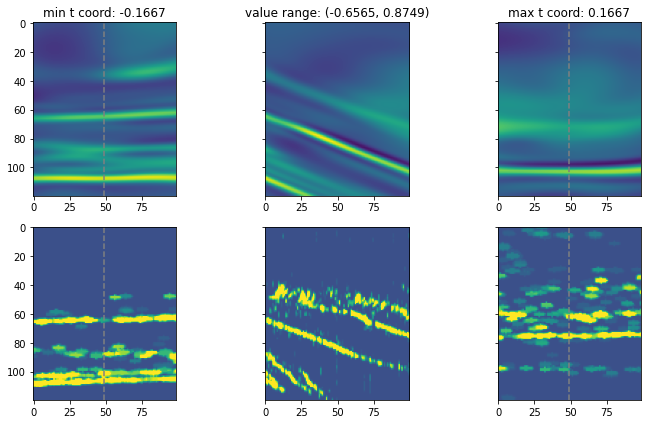

In [ ]:
from surfbreak.train_utils import waveform_tensors_plot
wf_gt_txy = ground_truth['all_wavefront_values'].reshape(ground_truth['full_tensor_shape'])
wf_out_txy = wf_values_out.reshape(ground_truth['full_tensor_shape']).detach().numpy()
fig = waveform_tensors_plot(wf_out_txy, wf_gt_txy, coords=coords_out)

tensor([[  0, 120],
        [  3, 120],
        [  6, 120],
        [  9, 120],
        [ 12, 120]])


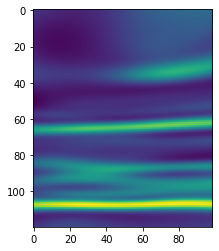

In [ ]:
import matplotlib.pyplot as plt
indexes = torch.tensor([[x*3,120] for x in range(5)])
print(indexes)
wf_out_xy = wf_out_txy[0,...]
idx_values = torch.index_select(wf_out_txy, )
plt.imshow(wf_out_xy.T)

In [ ]:
from surfbreak.supervision import animate_tensor
animate_tensor(wf_out_txy.transpose(2,1,0), colorbar=True)